In [1]:
# 以下が必要
# conda install pandas-profiling
# conda install category_encoders -y
# conda install graphviz -y
# conda install python-graphviz -y
# conda install -c saravji boruta -y

In [104]:
%ls

 ドライブ C のボリューム ラベルは Windows です
 ボリューム シリアル番号は CA67-50C9 です

 C:\Users\tsk_sato\Documents\DataAnalysisProjects のディレクトリ

2019/03/27  17:23    <DIR>          .
2019/03/27  17:23    <DIR>          ..
2018/08/30  15:52                20 .gitignore
2019/03/27  16:52    <DIR>          .ipynb_checkpoints
2018/08/24  13:25             2,141 anomaly_detection_method_evaluation.py
2019/03/27  14:59             4,398 CV_Kperiod.ipynb
2019/03/25  17:56    <DIR>          data
2019/03/18  17:40             2,607 EDA_GMS.ipynb
2019/03/18  17:49            23,945 folium_uktaxi.ipynb
2018/08/23  15:12             5,577 GMM_SkillCraft1.ipynb
2018/08/23  15:13             5,697 KDE_SkillCraft1.ipynb
2019/03/18  17:49            13,765 keras_001.ipynb
2018/08/30  15:49             9,149 LOF_SkillCraft1.ipynb
2019/03/19  16:35            31,153 MTS_SkillCraft1.ipynb
2019/03/18  17:49    <DIR>          output
2018/09/03  11:16                66 README.md
2019/03/20  14:37           662,942 Template.ipynb
201

In [105]:
import warnings
warnings.filterwarnings("ignore")
import category_encoders as ce
import graphviz
import itertools
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling as pdp
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, train_test_split
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 300)

# データ読み込み

In [106]:
%time
file_name = "../python_codes/data/mushroom.csv"
df = pd.read_csv(file_name, header=None, index_col=None, sep=',')

Wall time: 0 ns


In [107]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m


In [108]:
# レポート作成
pdp.ProfileReport(df)

Number of variables,23
Number of observations,8124
Total Missing (%),0.0%
Total size in memory,1.4 MiB
Average record size in memory,184.0 B
Numeric,0
Categorical,22
Date,0
Text (Unique),0
Rejected,1
Distinct count,2


In [109]:
# 行数列数
df.shape

(8124, 23)

In [110]:
# カラムの型
df.dtypes

0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
13    object
14    object
15    object
16    object
17    object
18    object
19    object
20    object
21    object
22    object
dtype: object

In [111]:
# 基本統計量
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [112]:
# 欠損値確認
df.isnull().any(axis=0)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
dtype: bool

In [113]:
# 欠損個数確認
df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
dtype: int64

In [114]:
# '?'を含む行数を確認
stats = []
for col in df.columns:
    stats.append(
        (col,                                                                      # 列名
         df[col].nunique(),                                                        # ユニークな値をカウント
         (df[col]=='?').sum() * 100 / df.shape[0]                                  # 欠損値の割合
            if not np.issubdtype(df[col].dtype, np.number) else 0.0,              # 数値型か確認
         df[col].value_counts(normalize=True, dropna=False).values[0] * 100,      # 最大派閥に属するカテゴリ割合 
         df[col].dtype)                                                           # 型
    )
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
11,11,5,30.526834,46.479567,object
12,12,4,0.000000,63.712457,object
21,21,6,0.000000,49.729197,object
20,20,9,0.000000,29.394387,object
19,19,5,0.000000,48.842935,object
18,18,3,0.000000,92.171344,object
17,17,4,0.000000,97.538159,object
16,16,1,0.000000,100.000000,object
15,15,9,0.000000,53.963565,object
14,14,9,0.000000,54.948301,object


In [122]:
# 少数派のカテゴリ割合を計算
for col in df.columns:
    print(df[col].value_counts(normalize=True, dropna=False)*100)
    print("="*40)

e    51.797144
p    48.202856
Name: 0, dtype: float64
x    45.002462
f    38.798621
k    10.192024
b     5.563762
s     0.393895
c     0.049237
Name: 1, dtype: float64
y    39.931068
s    31.462334
f    28.557361
g     0.049237
Name: 2, dtype: float64
n    28.114229
g    22.648941
e    18.463811
y    13.195470
w    12.801576
b     2.067947
p     1.772526
c     0.541605
r     0.196947
u     0.196947
Name: 3, dtype: float64
f    58.444116
t    41.555884
Name: 4, dtype: float64
n    43.426883
f    26.587888
y     7.090103
s     7.090103
l     4.923683
a     4.923683
p     3.151157
c     2.363368
m     0.443131
Name: 5, dtype: float64
f    97.415066
a     2.584934
Name: 6, dtype: float64
c    83.85032
w    16.14968
Name: 7, dtype: float64
b    69.079271
n    30.920729
Name: 8, dtype: float64
b    21.270310
p    18.365337
w    14.795667
n    12.900049
g     9.256524
h     9.010340
u     6.056130
k     5.022157
e     1.181684
y     1.058592
o     0.787789
r     0.295421
Name: 9, dtype: float

In [72]:
df[df[11]=='?'].head(3)

,0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,19,20,21,22
3984,e,x,y,b,t,n,c,b,e,e,?,s,s,e,w,e,w,c,w
4023,p,x,y,e,f,y,c,n,b,t,?,k,s,w,w,e,w,v,p
4076,e,f,y,u,f,n,c,n,h,e,?,s,f,w,w,f,h,y,d


- 列名16が定数なので除去対称
- 列名11が欠損値?を含むので対応が必要
- 列名6, 17, 18が最大派閥に含まれるカテゴリが9割以上で、除去対称になるかも
- カテゴリカル変数で少数派なものがいくつかあるので1%に満たないカテゴリはダミーで置き換え

In [15]:
# 不均衡カラムの除去
good_cols = list(df.columns)
for col in df.columns:
    rate = df[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
df = df[good_cols]

In [123]:
# バックオフ：少数派カテゴリを抽出
def backoff_cand(df, cutoff=0.01):
    cand = {}
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            continue
        else:
            tmp_df = df[col].value_counts(normalize=True, dropna=False)
            for idx in tmp_df.index:
                if tmp_df[idx] < cutoff:
                    if cand.get(col) is None:
                        cand.setdefault(col, [idx])
                    else:
                        cand[col].append(idx)
    return cand


# バックオフ：少数派カテゴリをダミーで置き換え
def backoff_replace(df, cand, sep="_dum_"):
    _df = pd.DataFrame({})
    cols = []
    for key, val in cand.items():
        tmp = df[key]
        for idx in val:
            tmp = tmp.replace(idx, sep)
        col_name = "_"+str(key)+"_"
        _df[col_name] = tmp
        cols.append(col_name)
    return _df[cols]


cand = backoff_cand(df)
backoff =  backoff_replace(df, cand)
df = pd.concat([df, backoff], axis=1)

In [124]:
# 欠損値の補完
#----------------------------------------------#
# ここでは欠損値 ? もひとつのカテゴリとして扱うことに
#----------------------------------------------#

# とりあえず平均値で補完
# mean_Age = df[(df['Age']!='?')]['Age'].values.astype('float').mean()
# mean_TotalHours = df[(df['TotalHours']!='?')]['TotalHours'].values.astype('float').mean()
# mean_HoursPerWeek = df[(df['HoursPerWeek']!='?')]['HoursPerWeek'].values.astype('float').mean()
# 平均値を代入
# df.loc[df['Age']=='?', 'Age'] = mean_Age
# df.loc[df['TotalHours']=='?', 'TotalHours'] = mean_TotalHours
# df.loc[df['HoursPerWeek']=='?', 'HoursPerWeek'] = mean_HoursPerWeek

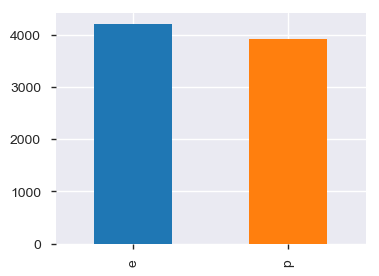

In [125]:
# ターゲットカラム集計
plt.figure(figsize=(4,3))
df[0].value_counts().plot.bar()
plt.show()

# 学習

In [18]:
target_col = 0
delete_col = [target_col]
y = df[target_col]
X = df.drop(delete_col, axis=1)

In [19]:
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
print(y)
y = le.inverse_transform(y)
print(y)

[1 0 0 ... 0 1 0]
['p' 'e' 'e' ... 'e' 'p' 'e']


In [20]:
pd.get_dummies(y).head()

,e,p
0,0,1
1,1,0
2,1,0
3,0,1
4,1,0


In [21]:
# e=1, p=0 と変換
y = le.transform(y)

In [22]:
# One-Hot encoding
ce_ohe = ce.one_hot.OneHotEncoder(drop_invariant=True, handle_unknown="ignore")
X = ce_ohe.fit_transform(X)

In [23]:
# 訓練データと評価データを生成
X_train, X_test, y_train, y_test = train_test_split(X, y)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [24]:
# Training APIを利用した書き方
# パラメータ設定
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'binary_logloss'},
        'learning_rate': 0.1,
        'num_leaves': 32,
        'min_data_in_leaf': 3,
        'num_iteration': 200,
        'verbose': -1,
        'seed': 40002
}
# 学習
gbm = lgb.train(params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    early_stopping_rounds=20
)

[1]	valid_0's binary_logloss: 0.597788
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's binary_logloss: 0.519952
[3]	valid_0's binary_logloss: 0.455073
[4]	valid_0's binary_logloss: 0.400246
[5]	valid_0's binary_logloss: 0.35342
[6]	valid_0's binary_logloss: 0.313088
[7]	valid_0's binary_logloss: 0.27811
[8]	valid_0's binary_logloss: 0.247604
[9]	valid_0's binary_logloss: 0.220873
[10]	valid_0's binary_logloss: 0.197356
[11]	valid_0's binary_logloss: 0.176597
[12]	valid_0's binary_logloss: 0.158219
[13]	valid_0's binary_logloss: 0.141908
[14]	valid_0's binary_logloss: 0.127401
[15]	valid_0's binary_logloss: 0.114472
[16]	valid_0's binary_logloss: 0.102932
[17]	valid_0's binary_logloss: 0.0926156
[18]	valid_0's binary_logloss: 0.0833817
[19]	valid_0's binary_logloss: 0.0751073
[20]	valid_0's binary_logloss: 0.0676851
[21]	valid_0's binary_logloss: 0.0610214
[22]	valid_0's binary_logloss: 0.055034
[23]	valid_0's binary_logloss: 0.0496503
[24]	valid_0's binary_l

# 評価

In [25]:
# 予測
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_max = np.round(y_pred)

In [26]:
# 精度
accuracy_score(y_test, y_pred_max)

1.0

In [27]:
# 評価レポート
target_names = ['p', 'e']
print(classification_report(y_test, y_pred_max, target_names=target_names))

              precision    recall  f1-score   support

           p       1.00      1.00      1.00      1042
           e       1.00      1.00      1.00       989

   micro avg       1.00      1.00      1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



In [28]:
# 変数重要度
importance = pd.DataFrame(gbm.feature_importance(), index=gbm.feature_name(), columns=['importance'])
display(importance)

,importance
1_1,182
1_2,39
1_3,11
1_4,95
1_5,21
1_6,0
2_1,88
2_2,56
2_3,27
2_4,0


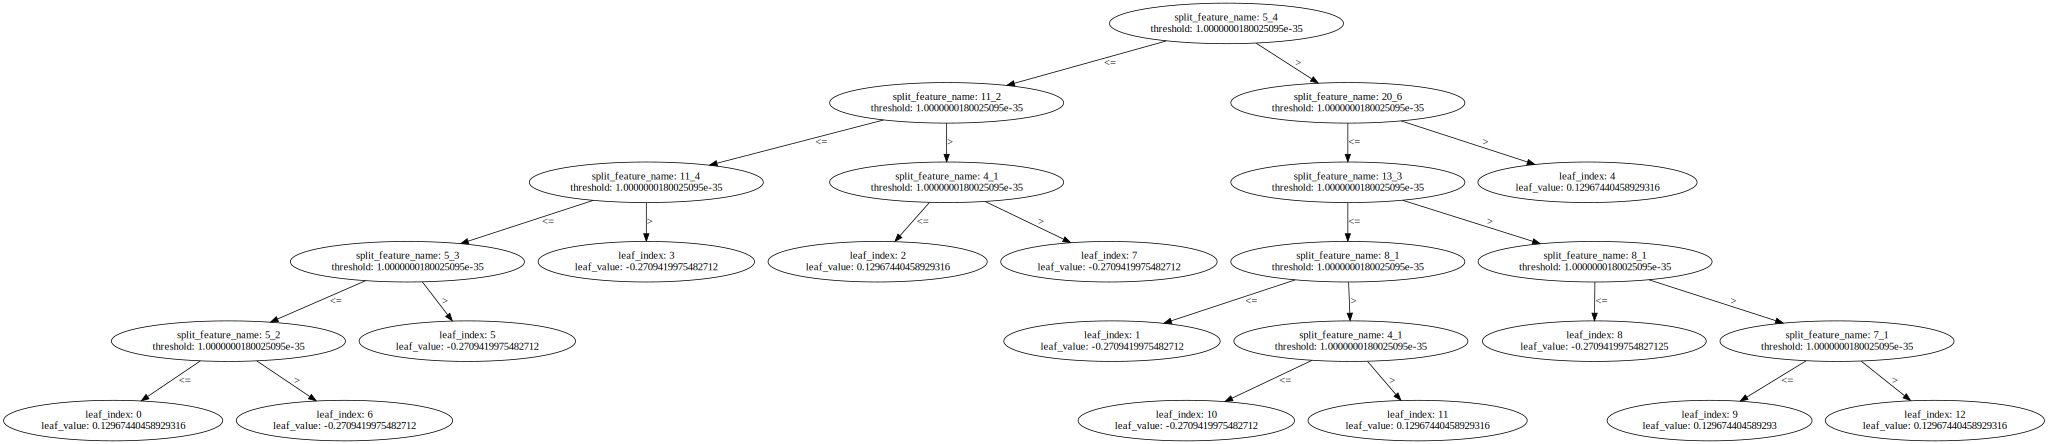

In [29]:
# 木の可視化 ... うまく描画するときとされないときがあるが ...
# lightgbm のいろいろな乱数シード依存な気がする
lgb.create_tree_digraph(gbm)
# graph.render(view=True)  # PDF に出力

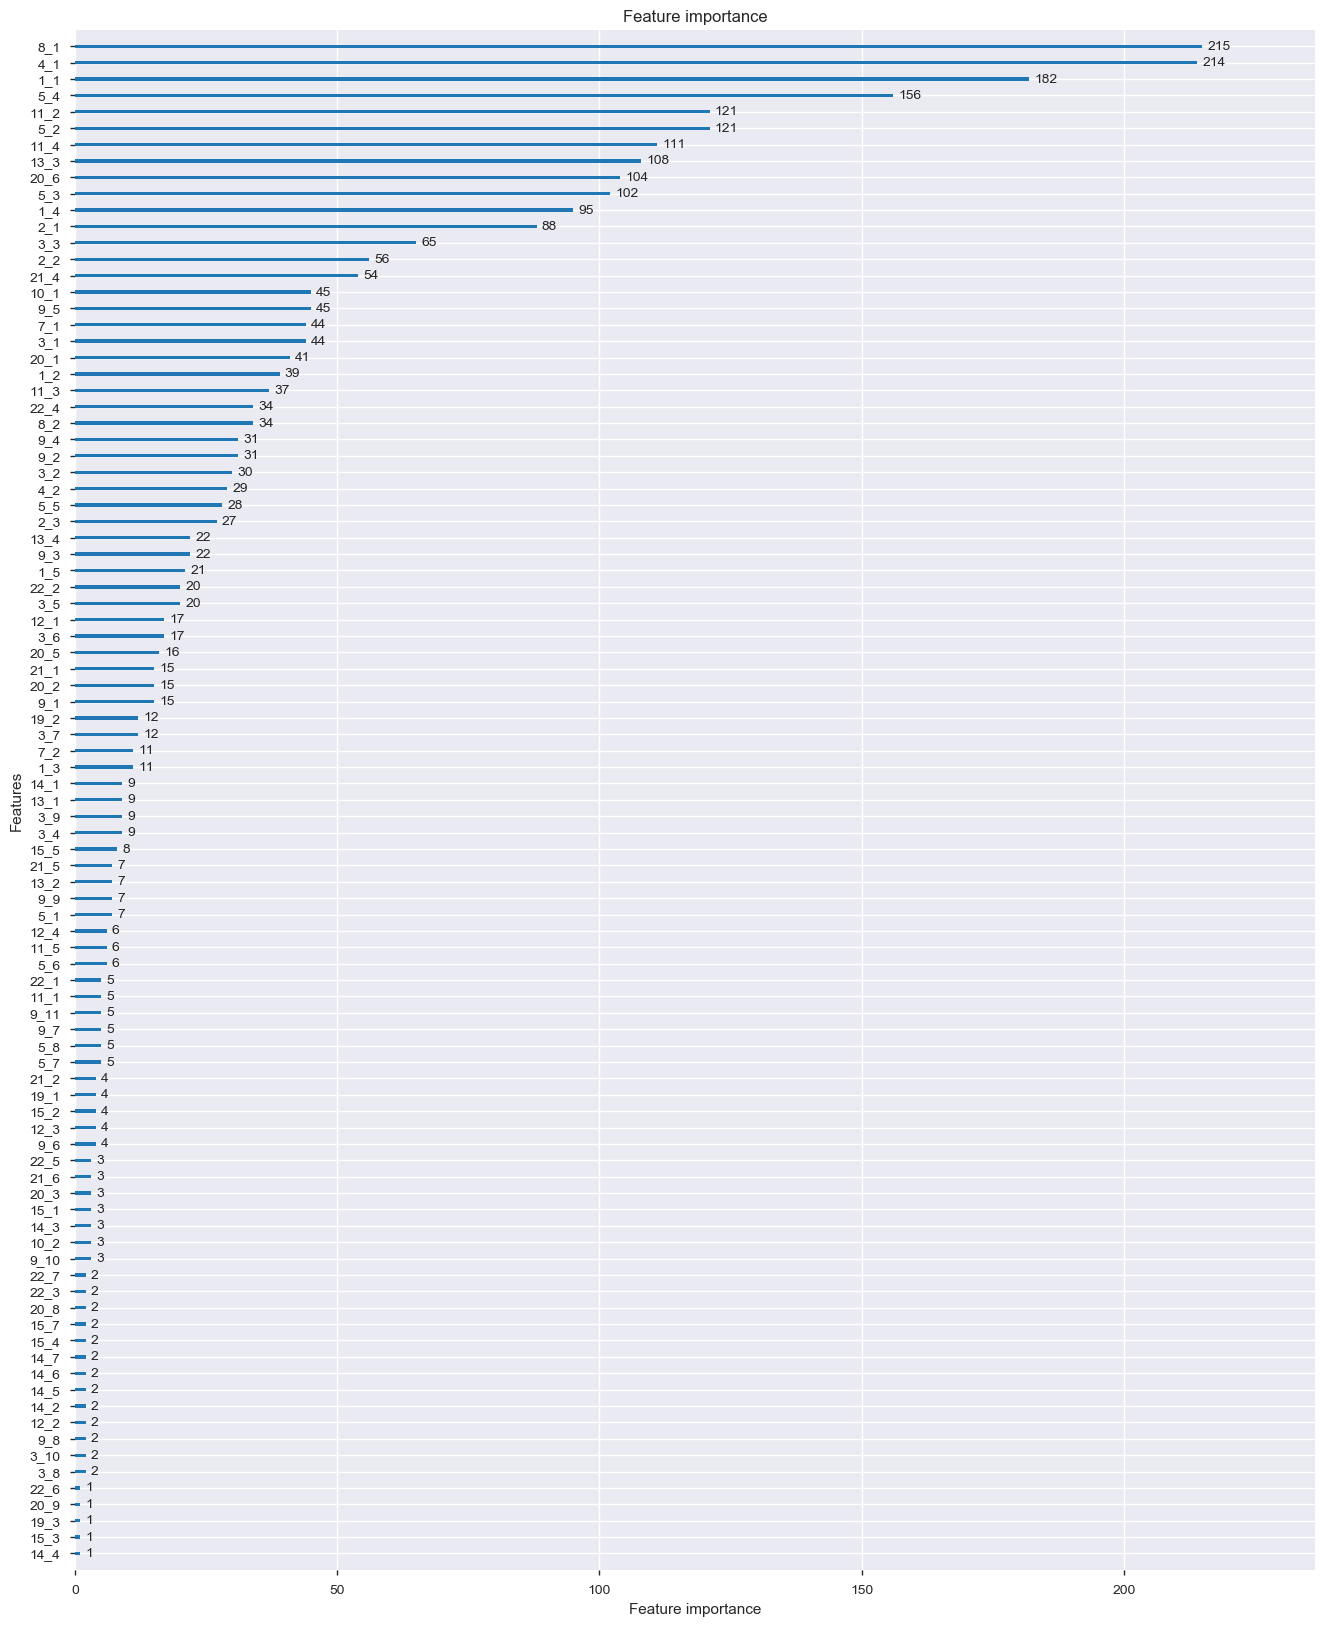

In [30]:
lgb.plot_importance(gbm, figsize=(16,20))
plt.show()

In [31]:
# scikit-learn API を利用
from sklearn.feature_selection import RFECV
gbm = lgb.LGBMClassifier(objective='binary',
                        num_leaves = 31,
                        learning_rate=0.1,
                        min_child_samples=10,
                        n_estimators=100)
selector = RFECV(gbm, step=1, cv=5)
selector = selector.fit(X_train, y_train)
print(selector.support_)
print(selector.ranking_)

[ True False False  True False False  True  True False False  True  True
  True False False False False False False False  True False False  True
  True  True False False False False False  True False  True False False
  True False False False False False False False False False False False
 False False  True False  True False False False False False False False
  True False False False False False False False False False False False
 False False False  True False False False False False False False False
 False  True False False False  True  True False False False False False
 False False False False False False False False False False False]
[ 1  3 17  1 18 68  1  1  8 75  1  1  1 32  2 15 27 28  6 53  1 12 78  1
  1  1 44 66 52 54 82  1 29  1 10 11  1  4  9  5 57 38 33 58 60 25 43 40
 72 62  1 36  1 87 35 37 42 85 20 65  1 79 19 77 61 64 81 45 70 83 73 23
 31 51 41  1 30 67 69 74 47 84 63 14 71  1 26 59 76  1  1 48 80 49 13 34
 50 16 55 24 86 39 56 46 22 21  7]


In [32]:
X_test.iloc[:, selector.support_].shape

(2031, 21)

In [33]:
# 予測
gbm.fit(X_train.iloc[:, selector.support_], y_train,
        eval_set=[(X_test.iloc[:, selector.support_], y_test)],
        eval_metric='binary_logloss',
        early_stopping_rounds=10)
y_pred_slapi = gbm.predict(X_test.iloc[:, selector.support_])

[1]	valid_0's binary_logloss: 0.598155	valid_0's binary_logloss: 0.598155
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.520629	valid_0's binary_logloss: 0.520629
[3]	valid_0's binary_logloss: 0.456017	valid_0's binary_logloss: 0.456017
[4]	valid_0's binary_logloss: 0.401424	valid_0's binary_logloss: 0.401424
[5]	valid_0's binary_logloss: 0.354803	valid_0's binary_logloss: 0.354803
[6]	valid_0's binary_logloss: 0.314653	valid_0's binary_logloss: 0.314653
[7]	valid_0's binary_logloss: 0.279838	valid_0's binary_logloss: 0.279838
[8]	valid_0's binary_logloss: 0.249478	valid_0's binary_logloss: 0.249478
[9]	valid_0's binary_logloss: 0.222878	valid_0's binary_logloss: 0.222878
[10]	valid_0's binary_logloss: 0.19948	valid_0's binary_logloss: 0.19948
[11]	valid_0's binary_logloss: 0.178805	valid_0's binary_logloss: 0.178805
[12]	valid_0's binary_logloss: 0.16051	valid_0's binary_logloss: 0.16051
[13]	valid_0's binary_logloss: 0.144273	valid_0's b

In [34]:
# 評価レポート
target_names = ['p', 'e']
print(classification_report(y_test, y_pred_slapi, target_names=target_names))

              precision    recall  f1-score   support

           p       1.00      1.00      1.00      1042
           e       1.00      1.00      1.00       989

   micro avg       1.00      1.00      1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



In [35]:
# 原因不明のエラー。。
# from boruta import boruta_py
# gbm = lgb.LGBMClassifier(objective='binary',
#                         num_leaves = 31,
#                         learning_rate=0.1)
# feat_selector = boruta_py.BorutaPy(gbm, n_estimators='auto')
# feat_selector.fit(X_train.values, y_train.values)